### Notebook to examine river runoff fluxes in MPAS-O and TXLA ROMS model 

In [48]:
#Packages 
import numpy as np
import xgcm
from xgcm import Grid
import xarray as xr
import xroms
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean.cm as cmo
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import warnings
warnings.filterwarnings("ignore") #turns off annoying warnings
#Cartopy
land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                edgecolor='face',
                                facecolor=cfeature.COLORS['land'])

states_provinces = cfeature.NaturalEarthFeature(
                   category='cultural',
                   name='admin_1_states_provinces_lines',
                   scale='10m',
                   facecolor='none')

In [238]:
#Simple test case for a 1 m water column for MPAS-O if the distribution
#was purely exponential
z = np.arange(-10,0,0.1)
gamma = 10
gamma_1 = 0.001
e_riv = np.exp(z/gamma)
e_surf = np.exp(z/gamma_1)

```
vi /usr/projects/climate/dschlichting/repos/E3SM/add-gom-grid/components/mpas-ocean/src/shared/mpas_ocn_diagnostics.F
3405      ! Compute fraction of thickness flux that is in the top model layer
3406      fracAbsorbed = 1.0_RKIND &
3407            - exp( max(-100.0_RKIND, &
3408                  -layerThickness(kmin, iCell)/ &
3409               config_flux_attenuation_coefficient))
3410      fracAbsorbedRunoff = 1.0_RKIND &
3411            - exp( max(-100.0_RKIND, &
3412                  -layerThickness(kmin, iCell)/ &
3413               config_flux_attenuation_coefficient_runoff))
```

In [227]:
#Calculate the amount of fresh water dumped into the top layer 
print(1.0 - np.exp(max(-100.0, -1 / 0.5)))
print(1.0 - np.exp(max(-100.0, -1 / 0.75)))
print(1.0 - np.exp(max(-100.0, -1 / 1)))
print(1.0 - np.exp(max(-100.0, -1 / 0.005)))

0.8646647167633873
0.7364028618842733
0.6321205588285577
1.0


### Plot the distribution. Note that anything below 1 meter is actually dumped into the bottom cells 

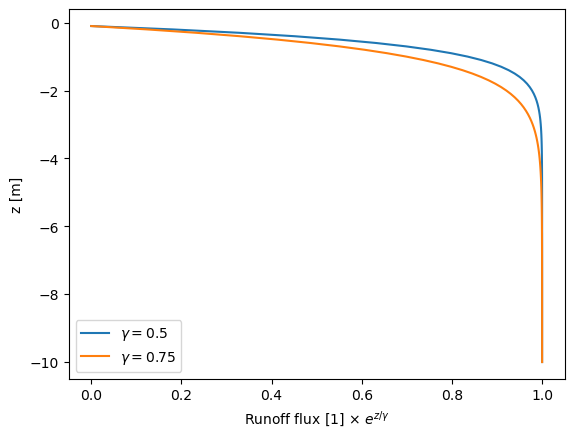

In [189]:
plt.plot(1-(np.exp(z/0.5)/max(np.exp(z/0.5))), z, label = '$\gamma=0.5$')
plt.plot(1-(np.exp(z/0.75)/max(np.exp(z/0.75))), z, label = '$\gamma=0.75$')
plt.xlabel(r'Runoff flux [1] $\times \, \,  e^{z/\gamma}$')
plt.ylabel('z [m]')
plt.legend()
# plt.gca().invert_yaxis()

(-4.0, 0.0)

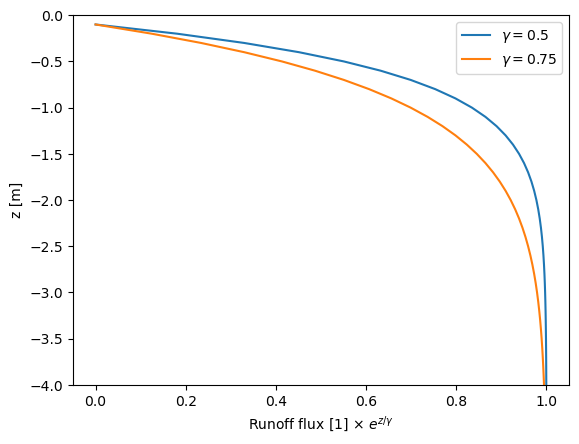

In [190]:
plt.plot(1-(np.exp(z/0.5)/max(np.exp(z/0.5))), z, label = '$\gamma=0.5$')
plt.plot(1-(np.exp(z/0.75)/max(np.exp(z/0.75))), z, label = '$\gamma=0.75$')
plt.xlabel(r'Runoff flux [1] $\times \, \,  e^{z/\gamma}$')
plt.ylabel('z [m]')
plt.legend()
plt.ylim(-4,0)
# plt.gca().invert_yaxis()

### Open up a ROMS forcing file to get an idea of how river fluxes are distributed 

In [50]:
dsr = xr.open_dataset('/global/cfs/cdirs/m4304/txla_mod/hindcast/inputs/rivers/txla2_river_2024_07_15_f.nc')
dsr

<xarray.Dataset> Size: 2MB
Dimensions:          (river: 58, s_rho: 30, river_time: 21)
Coordinates:
  * river            (river) float64 464B 1.0 2.0 3.0 4.0 ... 56.0 57.0 58.0
  * river_time       (river_time) datetime64[ns] 168B 2024-07-15 ... 2024-07-20
Dimensions without coordinates: s_rho
Data variables:
    river_Xposition  (river) float64 464B ...
    river_Eposition  (river) float64 464B ...
    river_direction  (river) float64 464B ...
    river_flag       (river) float64 464B ...
    river_Vshape     (s_rho, river) float64 14kB ...
    river_transport  (river_time, river) float64 10kB ...
    river_temp       (river_time, s_rho, river) float64 292kB ...
    river_salt       (river_time, s_rho, river) float64 292kB ...
    river_dye_01     (river_time, s_rho, river) float64 292kB ...
    river_dye_02     (river_time, s_rho, river) float64 292kB ...
    river_dye_03     (river_time, s_rho, river) float64 292kB ...
    river_dye_04     (river_time, s_rho, river) float64 292kB ...
Attributes:
    description:     river forcing file for TXLA ROFS
    type:            ROMS/TOMS river forcing input file
    data_source:     NOAA National Water Model
    date:            2024-07-15 06:53:38.160788
    source_file:     source file is /scratch/group/pong/TGLO/ROFS/inp_ext/NWM...
    source_content:  ,Mississippi,Atchafalaya,Trinity,Nueces,Sabine,Brazos,La...

Text(0.5, 1.0, 'ROMS river scheme')

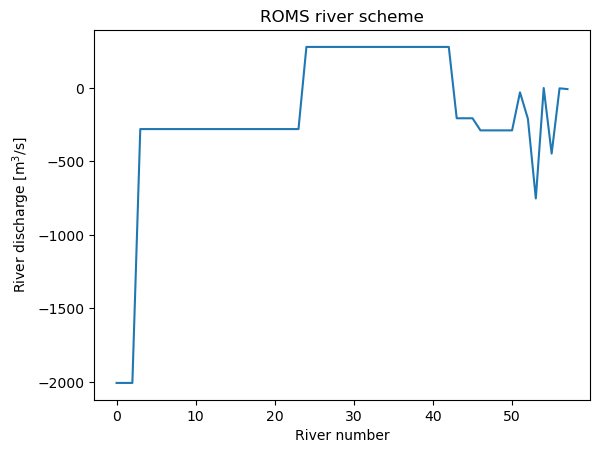

In [51]:
plt.plot(dsr.river_transport[0])
plt.xlabel('River number')
plt.ylabel(r'River discharge [m$^3$/s]')
plt.title('ROMS river scheme')

### Open sample model output and plot the vertical distribution for a point close to the coast

In [49]:
chunk = {"xi": -1, "eta": -1, "ocean_time": -1} 
chunks = {}
for sub in ["rho", "u", "v", "psi"]:
    for k, v in chunk.items():
        chunks[f"{k}_{sub}"] = v
chunks["ocean_time"] = chunk["ocean_time"]

path = '/pscratch/sd/d/dylan617/txla_roms/runs/forecast_test/TXLA2.ocn.his.2024_07_15_f.nc'
ds = xroms.open_netcdf(path,chunks=chunks)
ds,grid = xroms.roms_dataset(ds, include_cell_volume=True)
ds.xroms.set_grid(grid)

In [57]:
print(dsr.river_Xposition.values)
print(dsr.river_Eposition.values)

[574. 574. 575. 579. 581. 582. 582. 587. 583. 581. 580. 583. 584. 585.
 586. 587. 589. 590. 591. 592. 593. 594. 595. 596. 604. 604. 605. 603.
 602. 599. 600. 599. 601. 601. 601. 600. 601. 601. 601. 600. 600. 597.
 596. 445. 443. 444. 454. 455. 456. 457. 458. 338. 316. 284. 242. 202.
 190. 161.]
[ 41.  42.  43.  44.  45.  46.  47.  50.  51.  52.  53.  46.  46.  46.
  45.  45.  39.  37.  40.  41.  41.  41.  42.  43.  45.  46.  47.  48.
  49.  50.  51.  52.  56.  57.  58.  59.  60.  61.  62.  63.  64.  66.
  67. 175. 175. 175. 175. 175. 175. 175. 175. 190. 187. 188. 150. 182.
 180. 185.]


### Plot southwest pass

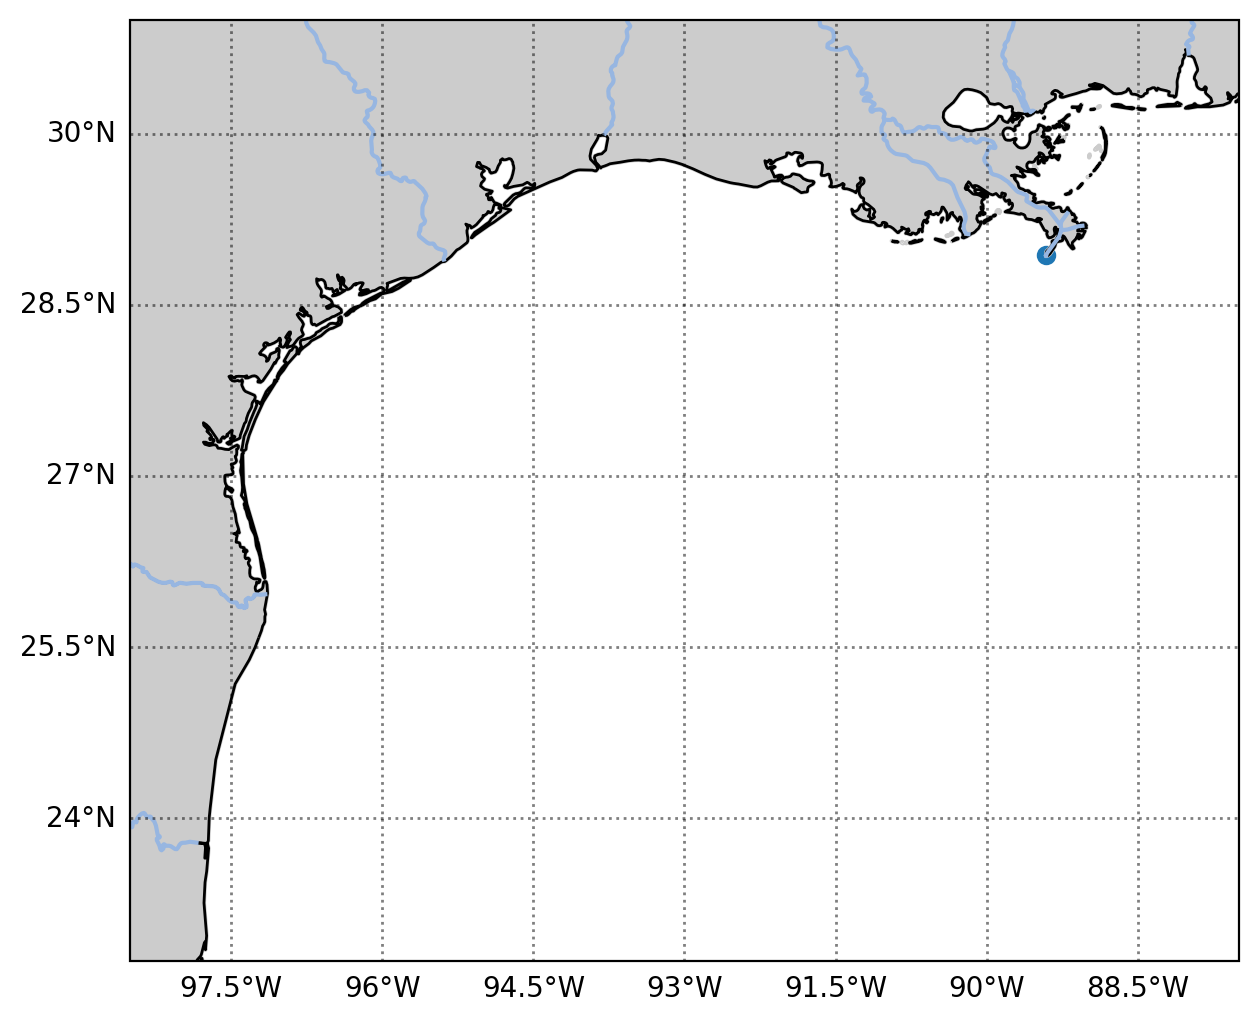

In [65]:
lat_rad = 1.0/np.cos(np.radians(ds.lat_rho.mean().values))

fig,ax = plt.subplots(1, figsize = (7,5), 
                      subplot_kw={'projection': ccrs.PlateCarree()}, 
                      constrained_layout = True, dpi = 200)

lon = ds.lon_rho.isel(xi_rho = int(dsr.river_Xposition[0]), 
                      eta_rho = int(dsr.river_Eposition[0]))
lat = ds.lat_rho.isel(xi_rho = int(dsr.river_Xposition[0]), 
                      eta_rho = int(dsr.river_Eposition[0]))
mappable = ax.scatter(lon, lat,transform = ccrs.PlateCarree())
ax.set_extent([-98.5, -87.5, 22.75, 31], ccrs.PlateCarree())
ax.set_aspect(lat_rad)

gl = ax.gridlines(linewidth=1, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.left_labels = True
gl.top_labels = False
gl.bottom_labels = True

ax.add_feature(land_10m, facecolor='0.8', linewidth = 1.5)
ax.coastlines(resolution='10m', linewidth = 1)  
ax.add_feature(cfeature.BORDERS, linewidth=1)
ax.add_feature(cartopy.feature.RIVERS, linewidth=1.5)
# ax.set_title('Sea surface salinity: July 15, 2024 00:00 UTC', fontsize = 11)
fig.canvas.draw()

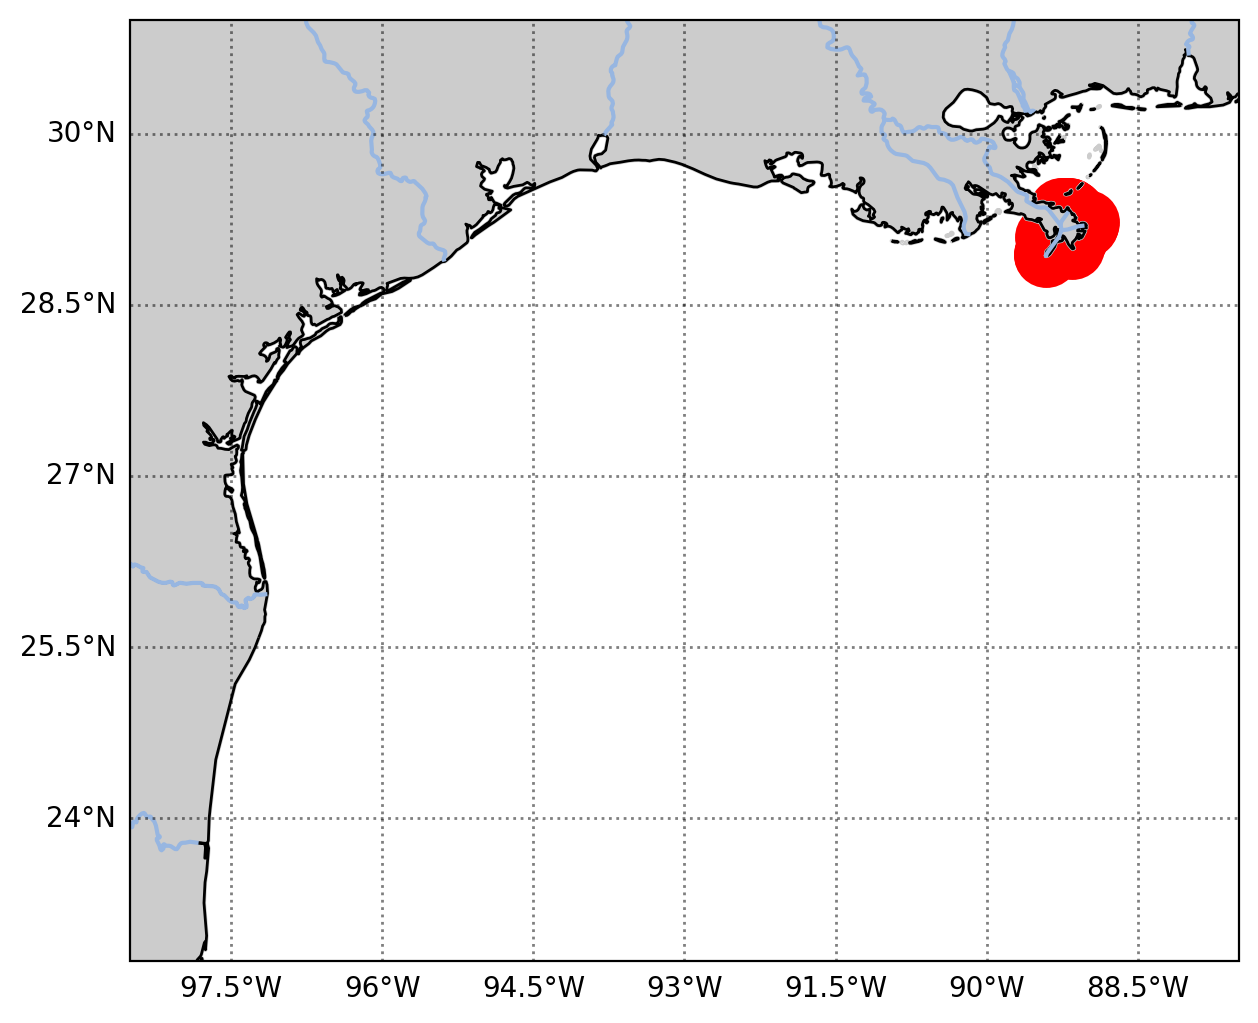

In [136]:
fig,ax = plt.subplots(1, figsize = (7,5), 
                      subplot_kw={'projection': ccrs.PlateCarree()}, 
                      constrained_layout = True, dpi = 200)
for i in range(43): # Brute force approximate river index to know where other rivers start
    lon = ds.lon_rho.isel(xi_rho = int(dsr.river_Xposition[i]), 
                          eta_rho = int(dsr.river_Eposition[i]))
    lat = ds.lat_rho.isel(xi_rho = int(dsr.river_Xposition[i]), 
                          eta_rho = int(dsr.river_Eposition[i]))
    mappable = ax.scatter(lon, lat, c = 'r', s = 500, transform = ccrs.PlateCarree())
ax.set_extent([-98.5, -87.5, 22.75, 31], ccrs.PlateCarree())
ax.set_aspect(lat_rad)

gl = ax.gridlines(linewidth=1, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.left_labels = True
gl.top_labels = False
gl.bottom_labels = True

ax.add_feature(land_10m, facecolor='0.8', linewidth = 1.5)
ax.coastlines(resolution='10m', linewidth = 1)  
ax.add_feature(cfeature.BORDERS, linewidth=1)
ax.add_feature(cartopy.feature.RIVERS, linewidth=1.5)
# ax.set_title('Sea surface salinity: July 15, 2024 00:00 UTC', fontsize = 11)
fig.canvas.draw()

### Get the water depth at southwest pass

In [198]:
ds.h.isel(xi_rho = int(dsr.river_Xposition[0]), 
          eta_rho = int(dsr.river_Eposition[0])-1).values

array(9.28041212)

### z_rho points 

In [203]:
zrho = ds.z_rho.isel(ocean_time = 0, 
                     xi_rho = int(dsr.river_Xposition[0]), 
                     eta_rho = int(dsr.river_Eposition[0]))
zrho.values

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan])

### Try nearest neigbor, there will be error for plots hereafter 

In [218]:
zrho = ds.z_rho_u.isel(ocean_time = 0, 
                     xi_u = int(dsr.river_Xposition[0]-1), 
                     eta_rho = int(dsr.river_Eposition[0]-1))
zrho.values

array([-9.01887144, -8.44796266, -7.91599144, -7.42109632, -6.96075354,
       -6.5320697 , -6.13200248, -5.75751905, -5.40570365, -5.07382551,
       -4.75937686, -4.46008962, -4.17393705, -3.89912558, -3.63408063,
       -3.37742909, -3.12798034, -2.88470721, -2.64672762, -2.41328748,
       -2.18374509, -1.95755717, -1.73426657, -1.51349156, -1.29491668,
       -1.07828497, -0.86339158, -0.65007863, -0.4382311 , -0.22777395])

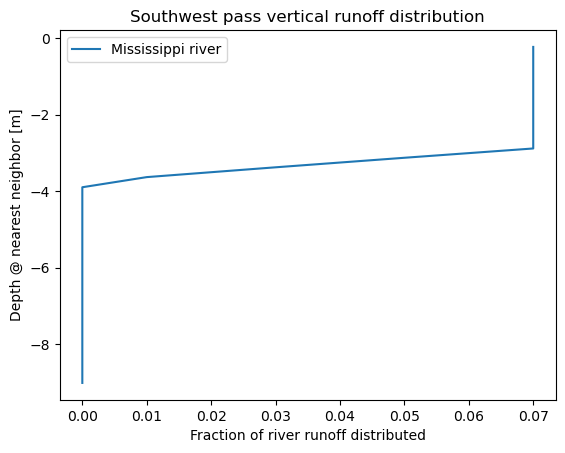

In [219]:
plt.plot(dsr.river_Vshape[:,0], zrho, label = 'Mississippi river')
plt.xlabel('Fraction of river runoff distributed')
plt.ylabel('Depth @ nearest neighbor [m]')
plt.title('Southwest pass vertical runoff distribution')
plt.legend()

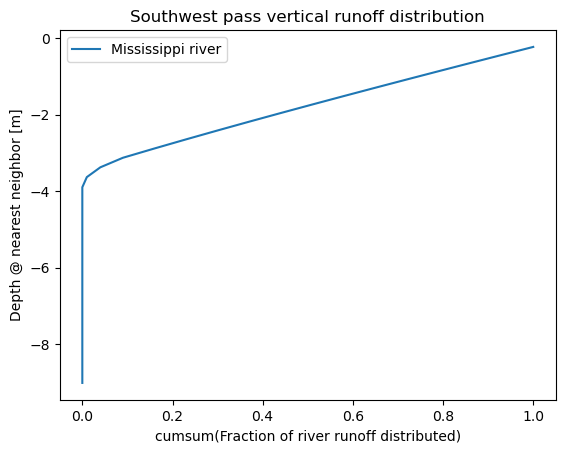

In [278]:
plt.plot(dsr.river_Vshape[:,0].cumsum('s_rho'), zrho, label = 'Mississippi river')
plt.xlabel('cumsum(Fraction of river runoff distributed)')
plt.ylabel('Depth @ nearest neighbor [m]')
plt.title('Southwest pass vertical runoff distribution')
plt.legend()
# plt.axhline(-1)

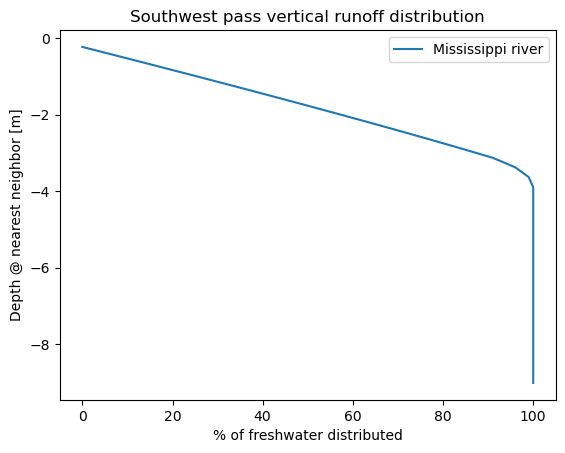

In [222]:
plt.plot((1-dsr.river_Vshape[:,0].cumsum('s_rho'))*100, zrho, label = 'Mississippi river')
plt.xlabel(r'% of freshwater distributed')
plt.ylabel('Depth @ nearest neighbor [m]')
plt.title('Southwest pass vertical runoff distribution')
plt.legend()

### Now let's assume it's an exponential so that it is similar to MPAS-O. That is, give it the spreading function of a Non-Miss river and replot 

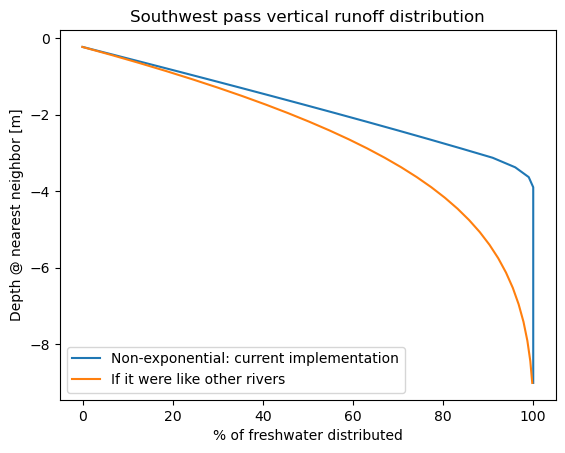

In [224]:
plt.plot((1-dsr.river_Vshape[:,0].cumsum('s_rho'))*100, zrho, label = 'Non-exponential: current implementation')
plt.plot((1-dsr.river_Vshape[:,-1].cumsum('s_rho'))*100, zrho, label = 'If it were like other rivers')
plt.xlabel(r'% of freshwater distributed')
plt.ylabel('Depth @ nearest neighbor [m]')
plt.title('Southwest pass vertical runoff distribution')
plt.legend()

### Now add in MPAS-O for a hypothetical comparison 

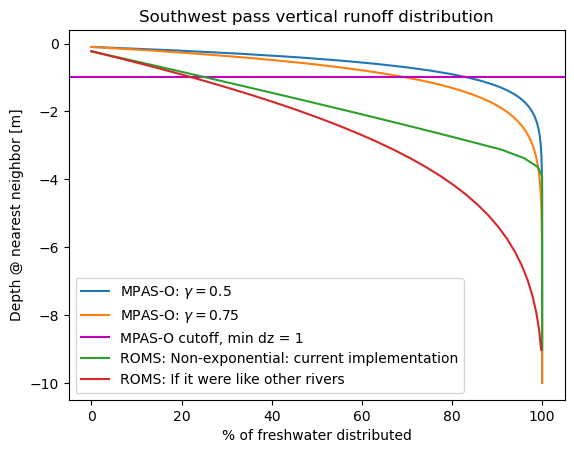

In [279]:
plt.plot((1-(np.exp(z/0.5)/max(np.exp(z/0.5))))*100, z, label = 'MPAS-O: $\gamma=0.5$')
plt.plot((1-(np.exp(z/0.75)/max(np.exp(z/0.75))))*100, z, label = 'MPAS-O: $\gamma=0.75$')
plt.axhline(-1, c = 'm', label = "MPAS-O cutoff, min dz = 1")
plt.plot((1-dsr.river_Vshape[:,0].cumsum('s_rho'))*100, zrho, label = 'ROMS: Non-exponential: current implementation')
plt.plot((1-dsr.river_Vshape[:,-1].cumsum('s_rho'))*100, zrho, label = 'ROMS: If it were like other rivers')

plt.xlabel(r'% of freshwater distributed')
plt.ylabel('Depth @ nearest neighbor [m]')
plt.title('Southwest pass vertical runoff distribution')
plt.legend()
plt.savefig('southwest_pass_river.jpg', dpi = 300)

### Zoom in 

(-4.0, 0.0)

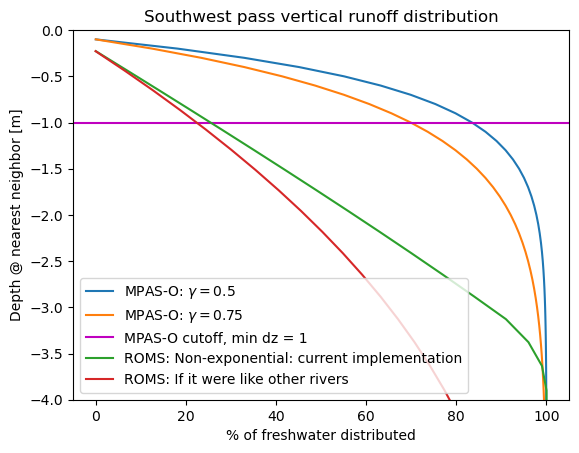

In [277]:
plt.plot((1-(np.exp(z/0.5)/max(np.exp(z/0.5))))*100, z, label = 'MPAS-O: $\gamma=0.5$')
plt.plot((1-(np.exp(z/0.75)/max(np.exp(z/0.75))))*100, z, label = 'MPAS-O: $\gamma=0.75$')
plt.axhline(-1, c = 'm', label = "MPAS-O cutoff, min dz = 1")
plt.plot((1-dsr.river_Vshape[:,0].cumsum('s_rho'))*100, zrho, label = 'ROMS: Non-exponential: current implementation')
plt.plot((1-dsr.river_Vshape[:,-1].cumsum('s_rho'))*100, zrho, label = 'ROMS: If it were like other rivers')

plt.xlabel(r'% of freshwater distributed')
plt.ylabel('Depth @ nearest neighbor [m]')
plt.title('Southwest pass vertical runoff distribution')
plt.legend()
plt.ylim(-4,0)

There are some substantial differences. MPAS-O will either put too much water in the top meter, or dump too much in the bottom. 